# Amazon Bestsellers Analysis

This notebook performs an analysis of the Amazon bestsellers dataset.

## 1. Importing Libraries

This cell imports the necessary Python libraries for data analysis, manipulation, and visualization.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## 2. Loading the Data

The dataset is loaded from the `Amazon_bestsellers_items_2025.csv` file into a pandas DataFrame.

In [5]:
df_bestsellers_2025 = pd.read_csv('Amazon_bestsellers_items_2025.csv', encoding='utf-8')

## 3. Data Cleaning and Preprocessing

This section focuses on cleaning the data, particularly the price and rating columns, to make them suitable for numerical analysis.

In [6]:
# Helper: parse prices for multiple locales/currencies into numeric native currency values
price_raw = df_bestsellers_2025['product_price'].astype(str)


# Map country to expected currency symbol/order for quick parsing

In [ ]:
currency_symbols = {
    'US': '$',
    'CA': '$',
    'AU': '$',
    'DE': '€',
    'FR': '€',
    'ES': '€',
    'IT': '€',
    'JP': '¥',
    'MX': '$',
    'IN': '\u20b9'
}

# Extract numeric characters regardless of symbol, commas, spaces

In [ ]:
price_native = price_raw.str.replace('[^0-9.]+', '', regex=True)

# Apply heuristic function

In [ ]:
def parse_locale_number(s):
    if pd.isna(s) or s == '':
        return np.nan
    # s currently stripped to digits and dots only by earlier regex; we need original to detect commas
    return pd.to_numeric(s, errors='coerce')

price_native_num = price_native.apply(parse_locale_number)

In [10]:
# Attach
if 'price_numeric' not in df_bestsellers_2025.columns:
    df_bestsellers_2025['price_numeric'] = price_native_num
else:
    # fill missing using our new parse
    df_bestsellers_2025['price_numeric'] = df_bestsellers_2025['price_numeric'].fillna(price_native_num)

# Stars and rating counts

In [ ]:

if 'star_numeric' not in df_bestsellers_2025.columns:
    df_bestsellers_2025['star_numeric'] = pd.to_numeric(df_bestsellers_2025['product_star_rating'], errors='coerce')
if 'num_ratings_numeric' not in df_bestsellers_2025.columns:
    df_bestsellers_2025['num_ratings_numeric'] = pd.to_numeric(df_bestsellers_2025['product_num_ratings'], errors='coerce')

# Country coverage and missingness

In [ ]:

missing_summary = df_bestsellers_2025[['price_numeric','star_numeric','num_ratings_numeric']].isna().groupby(df_bestsellers_2025['country']).mean().reset_index()

print('Calculated expanded numeric parsing and missingness by country.')
print(missing_summary.head())


Calculated expanded numeric parsing and missingness by country.
  country  price_numeric  star_numeric  num_ratings_numeric
0      AU           0.22          0.11                 0.11
1      CA           0.01          0.02                 0.02
2      DE           0.02          0.00                 0.00
3      ES           0.03          0.00                 0.00
4      FR           0.00          0.04                 0.04


# Correlations among numeric fields (overall and by country)

In [ ]:

num_cols = ['price_numeric','star_numeric','num_ratings_numeric','rank']
num_df = df_bestsellers_2025[num_cols].apply(pd.to_numeric, errors='coerce')
print('Overall correlations (Pearson):')
print(num_df.corr(method='pearson'))

Overall correlations (Pearson):
                     price_numeric  star_numeric  num_ratings_numeric  \
price_numeric             1.000000     -0.066710            -0.093276   
star_numeric             -0.066710      1.000000             0.126001   
num_ratings_numeric      -0.093276      0.126001             1.000000   
rank                     -0.010605     -0.095370            -0.187409   

                         rank  
price_numeric       -0.010605  
star_numeric        -0.095370  
num_ratings_numeric -0.187409  
rank                 1.000000  


# By country correlations for price vs stars and ratings vs stars

In [ ]:

by_country_corr = df_bestsellers_2025.groupby('country').apply(
    lambda g: pd.Series({
        'corr_price_star': g['price_numeric'].corr(g['star_numeric']),
        'corr_numratings_star': g['num_ratings_numeric'].corr(g['star_numeric'])
    })
).reset_index()
print('By country correlations:')
print(by_country_corr)

By country correlations:
  country  corr_price_star  corr_numratings_star
0      AU        -0.172445              0.022750
1      CA         0.099237              0.020649
2      DE        -0.018444              0.175409
3      ES         0.122758              0.325196
4      FR        -0.016516              0.258244
5      IN        -0.061596             -0.030442
6      IT        -0.113272              0.288099
7      JP         0.051133              0.164397
8      MX        -0.215516              0.001452
9      US         0.231012              0.240209


/tmp/ipykernel_56789/461302400.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_country_corr = df_bestsellers_2025.groupby('country').apply(


# Top products by weighted popularity (rating * log(1+num_ratings))

In [ ]:

df_bestsellers_2025['popularity_score'] = df_bestsellers_2025['star_numeric'] * np.log1p(df_bestsellers_2025['num_ratings_numeric'])

top_pop = df_bestsellers_2025.sort_values('popularity_score', ascending=False).head(15)[['country','rank','asin','product_title','price_numeric','star_numeric','num_ratings_numeric','popularity_score']]
print('Top 15 by popularity score:')
print(top_pop)


Top 15 by popularity score:
    country  rank        asin  \
449      DE    51  B0DGSZB3QQ   
470      DE    72  B0DFHKKKK2   
494      DE    96  B0CKRMN9BP   
429      DE    31  B0CFQ2R348   
399      DE     1  B0DGTG1BF6   
401      DE     3  B0CKWZWYQ6   
407      DE     9  B0DCRVR48W   
423      DE    25  B0BGKHN43R   
140      US    41  B0CJYL7JYV   
109      US    10  B0CLBV27N2   
30       IN    31  B073VL49H8   
33       IN    34  B073VKTK96   
27       IN    28  B073VMC9RZ   
60       IN    61  B073VMC9S1   
5        IN     6  B073VLNGJW   

                                         product_title  price_numeric  \
449  WISO Steuer 2025 (für Steuerjahr 2024) Für Win...        3499.00   
470  WISO Steuer 2025 (für Steuerjahr 2024)|Für Win...        3154.00   
494  WISO Steuer 2024 (für Steuerjahr 2023), Für Wi...        2921.00   
429  WISO Steuer 2024 (für Steuerjahr 2023), Für Wi...        2599.00   
399  WISO Steuer 2025 (für Steuerjahr 2024) Für Win...        2549.00   
401  

# Price bands and rating distribution

In [ ]:

bins = [0, 250, 500, 1000, 2000, 5000, np.inf]
labels = ['0-250','250-500','500-1000','1000-2000','2000-5000','5000+']
df_bestsellers_2025['price_band'] = pd.cut(df_bestsellers_2025['price_numeric'], bins=bins, labels=labels, include_lowest=True)

band_summary = df_bestsellers_2025.groupby(['country','price_band']).agg(
    avg_rating=('star_numeric','mean'),
    median_price=('price_numeric','median'),
    count=('asin','count')
).reset_index()
print('Price band summary (first rows):')
print(band_summary.head(20))

Price band summary (first rows):
   country price_band  avg_rating  median_price  count
0       AU      0-250    4.250820         66.00     69
1       AU    250-500    4.150000        341.44      8
2       AU   500-1000         NaN        897.49      1
3       AU  1000-2000         NaN           NaN      0
4       AU  2000-5000         NaN           NaN      0
5       AU      5000+         NaN           NaN      0
6       CA      0-250    4.050000         39.99     93
7       CA    250-500    3.825000        310.94      4
8       CA   500-1000    5.000000        698.50      2
9       CA  1000-2000         NaN           NaN      0
10      CA  2000-5000         NaN           NaN      0
11      CA      5000+         NaN           NaN      0
12      DE      0-250         NaN           NaN      0
13      DE    250-500         NaN           NaN      0
14      DE   500-1000    4.133333        884.00      6
15      DE  1000-2000    4.193333       1565.50     30
16      DE  2000-5000    4.43181

/tmp/ipykernel_56789/122973034.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_summary = df_bestsellers_2025.groupby(['country','price_band']).agg(


/tmp/ipykernel_56789/2963393616.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_bestsellers_2025, x='country', y='price_numeric', palette='viridis')


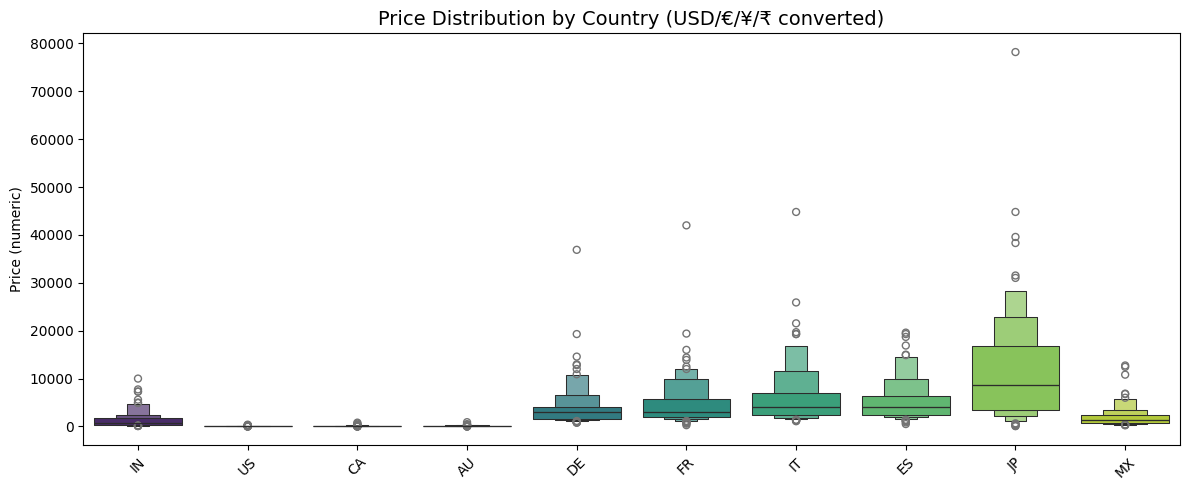

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxenplot(data=df_bestsellers_2025, x='country', y='price_numeric', palette='viridis')
plt.title('Price Distribution by Country (USD/€/¥/₹ converted)', fontsize=14)
plt.ylabel('Price (numeric)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_56789/3433794250.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_bestsellers_2025, x='country', y='star_numeric',palette="pastel")


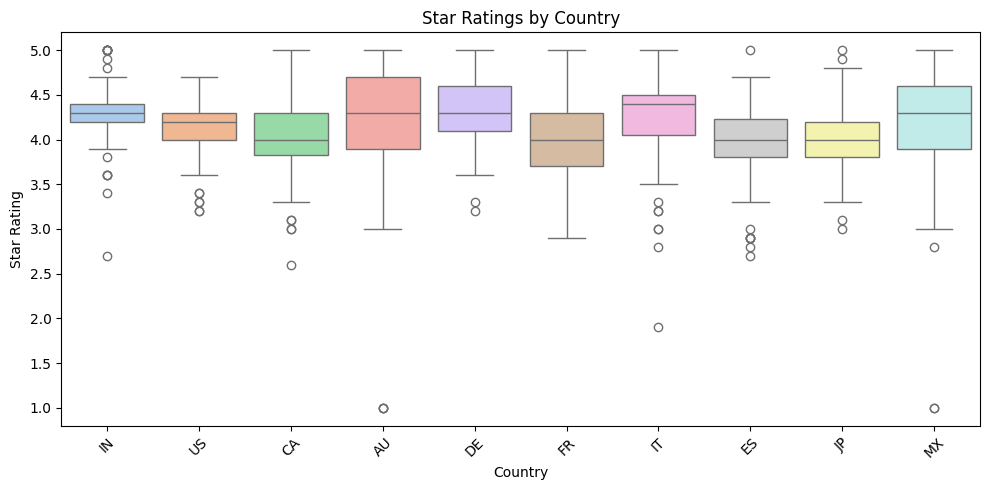

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_bestsellers_2025, x='country', y='star_numeric',palette="pastel")
plt.title('Star Ratings by Country')
plt.xlabel('Country')
plt.ylabel('Star Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_56789/635582799.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_bestsellers_2025, x='country', y='price_numeric',palette="viridis")


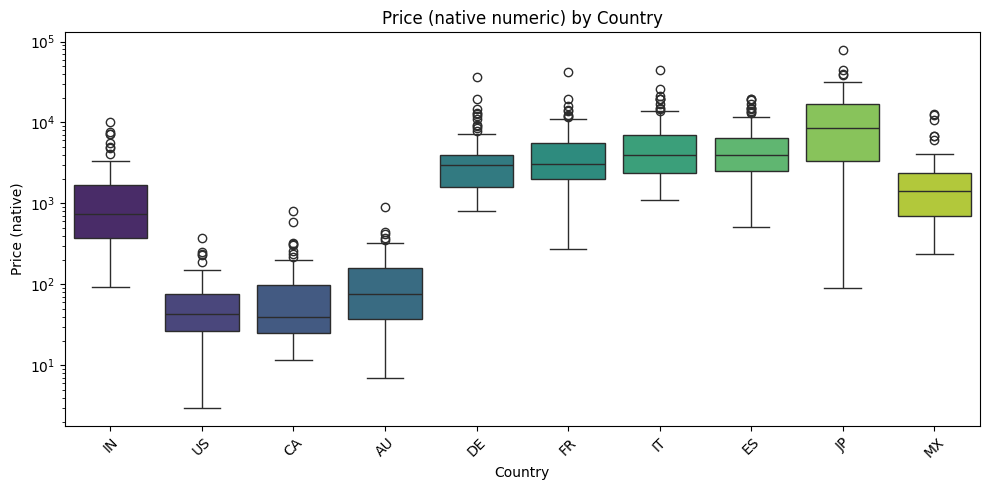

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_bestsellers_2025, x='country', y='price_numeric',palette="viridis")
plt.title('Price (native numeric) by Country')
plt.xlabel('Country')
plt.ylabel('Price (native)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# %% Cell – Interactive scatter (NaN-safe)
clean = df_bestsellers_2025.dropna(
    subset=['price_numeric', 'star_numeric', 'num_ratings_numeric']
)

fig = px.scatter(
    clean,
    x='price_numeric',
    y='star_numeric',
    color='country',
    hover_name='product_title',
    size='num_ratings_numeric',
    log_x=True,
    title='Price vs Rating (hover for title, size = #reviews)'
)
fig.update_layout(height=400)
fig.show()

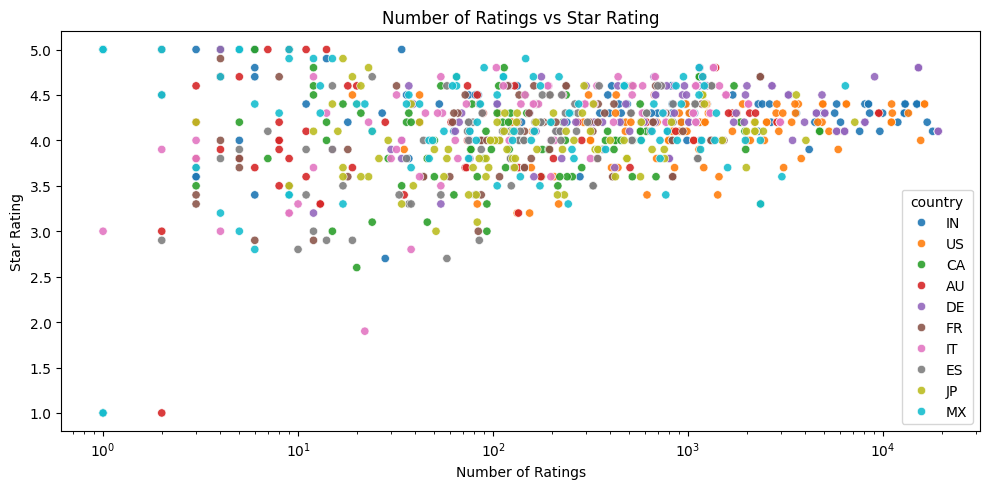

In [ ]:

plt.figure(figsize=(10,5))
sns.scatterplot(data=df_bestsellers_2025, x='num_ratings_numeric', y='star_numeric', hue='country', alpha=0.9)
plt.title('Number of Ratings vs Star Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Star Rating')
plt.xscale('log')
plt.tight_layout()
plt.show()